# ACTL3143/5111 Week 3 StoryWall Notebook

## Load Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.metrics import AUC, Accuracy

## Import Data

In [2]:
freq = pd.read_csv("stroke.csv")
freq

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## Pre-process Data

Splitting target and features

In [3]:
#drop id column
freq = freq.drop("id", axis=1)

In [4]:
#set target to stroke
target = freq['stroke']

#set features to all columns except stroke
features = freq.drop("stroke", axis=1)


Exploratory analysis

In [5]:
# Number of features and categories
NUM_FEATURES = len(features.columns)
NUM_CATS = len(np.unique(target))
print("Number of features:", NUM_FEATURES)
print("Number of categories:", NUM_CATS)

Number of features: 10
Number of categories: 2


In [6]:
#information about data
freq.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
#list of values in features
freq.describe(include="all")


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


In [8]:
#check for null values
freq.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [9]:
# check dataset imbalance
neg, pos = np.bincount(freq['stroke'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 5110
    Positive: 249 (4.87% of total)



### Convert strings to boolean

In [10]:
#yes/no to 1/0 for ever_married column
features['ever_married'] = features['ever_married'].replace(['Yes', 'No'], [1, 0])

### Split data into train and test set

In [11]:
#split data into train, val and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=17)

### Apply transformation

In [12]:
# Categorical boolean mask to be hot-encoded
categorical_features_mask = (features.dtypes==object)
numerical_features_mask = (features.dtypes!=object)

#filter categorical columns using mask and turn into a list
catVars = features.columns[categorical_features_mask].tolist()
catVars

['gender', 'work_type', 'Residence_type', 'smoking_status']

In [13]:
# Numerical boolean mask to be hot-encoded
numerical_features_mask = (features.dtypes!=object)

#filter categorical columns using mask and turn into a list
numerical_cols = features.columns[numerical_features_mask].tolist()
numerical_cols.remove("ever_married")
numerical_cols.remove("hypertension")
numerical_cols.remove("heart_disease")

numerical_cols

['age', 'avg_glucose_level', 'bmi']

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

ct = make_column_transformer(
  (OneHotEncoder(handle_unknown="ignore"), catVars),
  ("passthrough", ["hypertension", "heart_disease"]),
  remainder=make_pipeline(SimpleImputer(), StandardScaler())
)

In [26]:
#apply to train, val and test data
X_train_ct = ct.fit_transform(X_train)
X_val_ct = ct.transform(X_val)
X_test_ct = ct.transform(X_test)

X_train_ct.shape, X_val_ct.shape, X_test_ct.shape

((3066, 20), (1022, 20), (1022, 20))

## Setup a binary classification model

In [27]:
def create_model(seed=42):
    tf.random.set_seed(seed)
    model = Sequential()
    model.add(Dense(32, "leaky_relu", input_shape=X_train_ct.shape[1:]))
    model.add(Dense(16, "leaky_relu"))
    model.add(Dense(1, "sigmoid"))
    return model

In [28]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                672       
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________


### Add Metrics, compile and fit

In [29]:
model = create_model()

pr_auc = tf.keras.metrics.AUC(curve="PR", name="pr_auc")
model.compile(optimizer="adam", loss="BinaryCrossentropy",
    metrics=["accuracy", "AUC", pr_auc])

es = EarlyStopping(patience=50, restore_best_weights=True,
    monitor="val_pr_auc", verbose=1)
model.fit(X_train_ct, y_train, callbacks=[es], epochs=1_000, verbose=0,
  validation_data=(X_val_ct, y_val));

Restoring model weights from the end of the best epoch: 4.
Epoch 54: early stopping


In [31]:
model.evaluate(X_val_ct, y_val, verbose=0)

[0.14467117190361023,
 0.9569471478462219,
 0.8455916047096252,
 0.14353077113628387]

## Try overweighting the minority class

In [32]:
model = create_model()

pr_auc = tf.keras.metrics.AUC(curve="PR", name="pr_auc")
model.compile(optimizer="adam", loss="BinaryCrossentropy",
    metrics=["accuracy", "AUC", pr_auc])

es = EarlyStopping(patience=50, restore_best_weights=True,
    monitor="val_pr_auc", verbose=1)
model.fit(X_train_ct, y_train, callbacks=[es], epochs=1_000, verbose=0,
  validation_data=(X_val_ct, y_val), class_weight={0: 1, 1: 10});

Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


In [33]:
model.evaluate(X_val_ct, y_val, verbose=0)

[0.3449535667896271,
 0.8522505164146423,
 0.8624628186225891,
 0.2082192450761795]

This model performs better so we will use it to evaluate performance on test set

In [34]:
model.evaluate(X_test_ct, y_test, verbose=0)

[0.35120996832847595,
 0.8434442281723022,
 0.8572736978530884,
 0.28307950496673584]

## Classification Metrics

In [35]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
y_pred = model.predict(X_test_ct)

32/32 [==============================] - 0s 483us/step


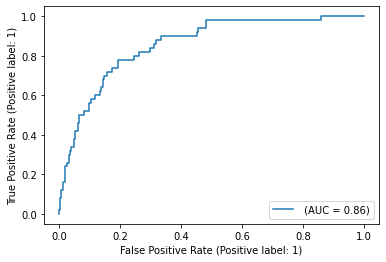

In [36]:
RocCurveDisplay.from_predictions(y_test, y_pred, name="");

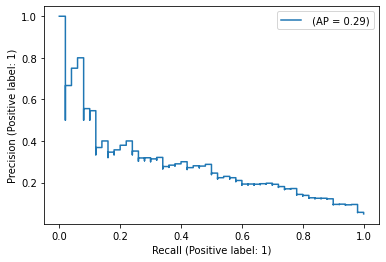

In [37]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name=""); plt.legend(loc="upper right");

In [38]:
y_pred_stroke = y_pred > 0.5
confusion_matrix(y_test, y_pred_stroke)

array([[827, 145],
       [ 15,  35]], dtype=int64)

In [39]:
y_pred_stroke = y_pred > 0.3
confusion_matrix(y_test, y_pred_stroke)

array([[610, 362],
       [  5,  45]], dtype=int64)